This Colab shows some example code how to make use of the
[LiT: Zero-Shot Transfer with Locked-image text Tuning](https://arxiv.org/abs/2111.07991)
models in the `big_vision` codebase.

For more information refer to

https://github.com/google-research/big_vision/blob/main/README.md

https://github.com/google-research/big_vision/blob/main/big_vision/configs/proj/image_text/README.md

### Initialize

In [1]:
!git clone --branch=main --depth=1 https://github.com/google-research/big_vision
!cd big_vision && git pull

Cloning into 'big_vision'...
remote: Enumerating objects: 96, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 96 (delta 13), reused 56 (delta 4), pack-reused 0
Unpacking objects: 100% (96/96), done.
Already up to date.


In [2]:
!pip install -qr big_vision/big_vision/requirements.txt

     |████████████████████████████████| 92 kB 826 kB/s 
     |████████████████████████████████| 197 kB 31.7 MB/s 
     |████████████████████████████████| 1.1 MB 67.0 MB/s 
     |████████████████████████████████| 4.6 MB 43.0 MB/s 
     |████████████████████████████████| 288 kB 54.8 MB/s 
     |████████████████████████████████| 72 kB 492 kB/s 
     |████████████████████████████████| 217 kB 34.5 MB/s 
     |████████████████████████████████| 596 kB 57.4 MB/s 
     |████████████████████████████████| 77 kB 7.0 MB/s 
     |████████████████████████████████| 4.3 MB 9.5 MB/s 
     |████████████████████████████████| 98 kB 5.2 MB/s 
     |████████████████████████████████| 51 kB 1.3 MB/s 
     |████████████████████████████████| 511.7 MB 6.3 kB/s 
     |████████████████████████████████| 511.7 MB 4.5 kB/s 
     |████████████████████████████████| 4.9 MB 48.6 MB/s 


In [3]:
import sys
bv_path = './big_vision'
if bv_path not in sys.path:
  sys.path.insert(0, bv_path)

%load_ext autoreload
%autoreload 2

In [4]:
from absl import flags
from absl import logging
import tensorflow_datasets as tfds
from google.colab import files

logging.set_verbosity(logging.INFO)

def set_max_height(max_height):
  """Limits scrollable area of output cell to `max_height` pixels."""
  import IPython.display
  IPython.display.display(IPython.display.Javascript('''
    google.colab.output.setIframeHeight(0, true, {maxHeight: %d})
  ''' % max_height))

In [5]:
# Set up Colab  TPUs (if available).
import os
if 'COLAB_TPU_ADDR' in os.environ:
  import jax.tools.colab_tpu
  jax.tools.colab_tpu.setup_tpu()
else:
  !nvidia-smi
import jax
jax.devices()

Sun Jun 26 14:04:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

INFO:absl:Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO:absl:Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.


[GpuDevice(id=0, process_index=0)]

In [6]:
# Uncomment this snippet to access a private GCS bucket with prepared
# TFDS datasets.

# import tensorflow_datasets as tfds
# from google.colab import auth
# auth.authenticate_user()  # Required to access access protected GCS buckets.
# import os
# os.environ['TFDS_DATA_DIR'] = 'gs://tensorflow-datasets/datasets'
# builder = tfds.builder('coco_captions')
# b = next(iter(builder.as_dataset('val')))

### Load training run data

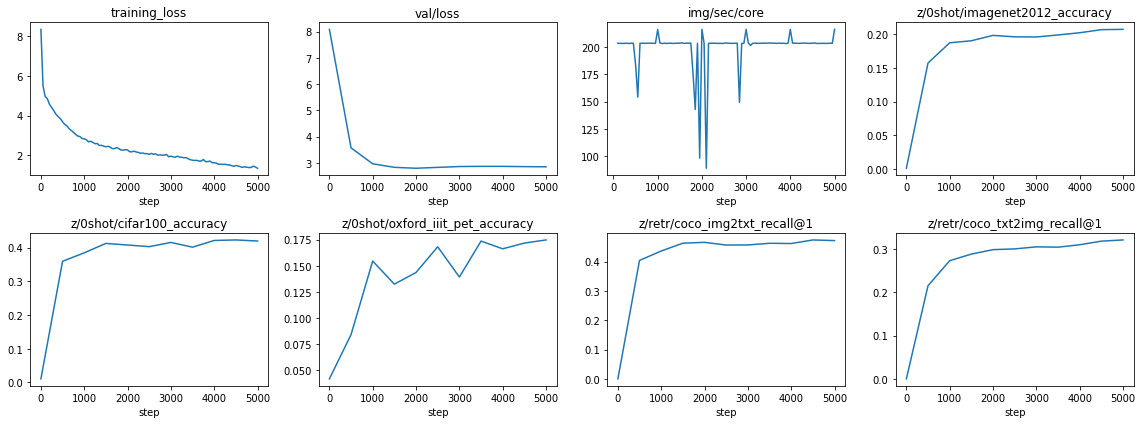

In [7]:
import json
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.io import gfile

def plot_metrics(workdir, regexes, cols=4, cmp={}):
  """Plots metrics matching `regexes` from `workdir`."""
  df = pd.DataFrame([json.loads(line) for line in gfile.GFile(f'{workdir}/big_vision_metrics.txt')])
  df = df.set_index('step')
  ms = []
  for regex in regexes:
    for col in df.columns:
      if col not in ms and re.match(regex, col):
        ms.append(col)
  rows = int(np.ceil(len(ms) / cols))
  _, axs = plt.subplots(rows, cols, figsize=(4*cols, 3*rows))
  if rows == 1: axs = [axs]
  for i, m in enumerate(ms):
    ax = axs[i // cols][i % cols]
    df[m].dropna().plot(ax=ax)
    if m in cmp: cmp[m].dropna().plot(ax=ax)
    ax.set_title(m)
  plt.tight_layout()
  return df

# Reference run using the tiny 80k "coco-captions" TFDS dataset.
df = plot_metrics('gs://vit_models/lit/big_vision/coco_B16B', [
    'training', 'val/loss', 'img/', '.*net2012',
    '.*cifar100', '.*pet', '.*@1$',
])

### Inference

Using an example from the online Demo

https://google-research.github.io/vision_transformer/lit/

--2022-06-26 14:04:07--  https://cdn.openai.com/multimodal-neurons/assets/apple/apple-ipod.jpg
Resolving cdn.openai.com (cdn.openai.com)... 13.107.246.40, 13.107.213.40, 2620:1ec:bdf::40, ...
Connecting to cdn.openai.com (cdn.openai.com)|13.107.246.40|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15783 (15K) [image/jpeg]
Saving to: ‘apple-ipod.jpg’

apple-ipod.jpg      100%[===================>]  15.41K  --.-KB/s    in 0s      

2022-06-26 14:04:07 (202 MB/s) - ‘apple-ipod.jpg’ saved [15783/15783]



((322, 322, 3), dtype('uint8'))

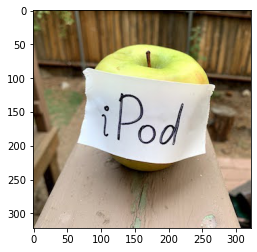

In [8]:
!test -f apple-ipod.jpg || wget https://cdn.openai.com/multimodal-neurons/assets/apple/apple-ipod.jpg

labels = [
    'an apple',
    'an ipod',
    'granny smith',
    'an apple with a note saying "ipod"',
    'an adversarial attack',
]

import PIL
import numpy as np
img = np.array(PIL.Image.open('apple-ipod.jpg'))
import matplotlib.pyplot as plt
plt.imshow(img)
img.shape, img.dtype

In [9]:
!test -f LiT-B16B.npz || gsutil cp gs://vit_models/lit/LiT-B16B.* .

Copying gs://vit_models/lit/LiT-B16B.npz...
Copying gs://vit_models/lit/LiT-B16B.txt...
- [2 files][747.6 MiB/747.6 MiB]   57.7 MiB/s                                   
Operation completed over 2 objects/747.6 MiB.                                    


In [10]:
files.view('big_vision/big_vision/configs/proj/image_text/lit_coco.py')
from big_vision.configs.proj.image_text import lit_coco
arg = 'txt=bert_base,img=B/16,img_head,init=LiT-B16B.npz'
config = lit_coco.get_config(arg)

<IPython.core.display.Javascript object>

In [11]:
# Initialize template params...
import importlib
import jax.numpy as jnp

model_mod = importlib.import_module(f'big_vision.models.{config.model_name}')

model = model_mod.Model(**config.model)

init_params = [
    jnp.zeros(shape, dtype)
    for shape, dtype in zip(config.init_shapes, config.init_types)
]

params0 = model.init(jax.random.PRNGKey(42), *init_params)['params'].unfreeze()

In [12]:
# ... and load/modify pre-trained params.
from big_vision import utils
# Note that `.load()` is responsible for parameter tree surgery to adapt old
# checkpoints to most recent source code.
params = model_mod.load(params0, 'LiT-B16B.npz', config.model)

INFO:absl:ViT: Loading and fixing VERY old posemb
INFO:absl:ViT: Loading and fixing combined cls+posemb
INFO:absl:
INFO:absl:
INFO:absl:Could not find original BERT checkpoint path 'LiT-B16B.npz:txt/bert_model.ckpt', loading big_vision checkpoint 'LiT-B16B.npz:txt'
INFO:absl:
INFO:absl:


In [13]:
# The preprocessing is optimized for efficiently streaming through TFDS
# datasets - below code runs it separately on the image and every text.
set_max_height(222)

from big_vision.pp import builder as pp_builder
for pp_mod in config.pp_modules:
  importlib.import_module(f'big_vision.pp.{pp_mod}')

imgs = np.array(pp_builder.get_preprocess_fn(config.pp_img)({
    'image': img[None],
})['image'])
txts = np.stack([
    pp_builder.get_preprocess_fn(config.pp_txt)({
        'label': label
    })['labels']
    for label in labels
])

<IPython.core.display.Javascript object>

INFO:absl:Data before pre-processing:
{'image': array([[[[123,  94,  52],
         [123,  96,  53],
         [139, 114,  74],
         ...,
         [ 64,  54,  19],
         [ 60,  54,  22],
         [ 54,  48,  16]],

        [[149, 125,  81],
         [149, 126,  84],
         [152, 130,  89],
         ...,
         [ 69,  55,  26],
         [ 61,  54,  28],
         [ 48,  41,  15]],

        [[152, 133,  91],
         [155, 138,  95],
         [153, 135,  95],
         ...,
         [ 75,  59,  33],
         [ 68,  60,  39],
         [ 45,  37,  16]],

        ...,

        [[112, 101,  73],
         [115, 103,  77],
         [177, 165, 141],
         ...,
         [ 15,   9,   9],
         [  1,   0,   0],
         [  1,   0,   0]],

        [[113,  98,  79],
         [160, 145, 126],
         [191, 175, 159],
         ...,
         [  3,   4,   6],
         [  0,   0,   0],
         [  0,   0,   0]],

        [[113,  98,  79],
         [160, 145, 126],
         [191, 175, 159],


In [14]:
zimg, _, _ = model.apply({'params': params}, imgs, None)
_, ztxt, _ = model.apply({'params': params}, None, txts)

In [15]:
probs = jax.nn.softmax((zimg[0] @ ztxt.T * np.exp(params['t'])))
list(zip(labels, probs.tolist()))

[('an apple', 0.0028924213256686926),
 ('an ipod', 1.8521586753195152e-06),
 ('granny smith', 1.0219752766715828e-05),
 ('an apple with a note saying "ipod"', 0.9970954656600952),
 ('an adversarial attack', 4.8630351301426344e-08)]

### Run evaluation

Below code runs a minimal version of the `big_vision.tols.eval_only` script.

In [16]:
files.view('big_vision/big_vision/tools/eval_only.py')
from big_vision.tools import eval_only

<IPython.core.display.Javascript object>

In [17]:
!test -f LiT-B16B.npz || gsutil cp gs://vit_models/lit/LiT-B16B.* .

In [18]:
from big_vision.configs.proj.image_text import lit_coco
arg = 'txt=bert_base,img=B/16,img_head,init=LiT-B16B.npz'
config = lit_coco.get_config(arg)

In [19]:
# From all the pre-defined evaluators...
set_max_height(222)
config.evals

<IPython.core.display.Javascript object>

coco:
  dataset: coco_captions
  log_steps: 500
  pp_fn: decode|resize(224)|value_range(-1,1)|flatten|bert_tokenize(inkey="captions/text",
    max_len=16, vocab_path="LiT-B16B.txt")|keep("image", "labels")
  split: val
  type: proj.image_text.contrastive
  use_global_batch: true
disclf:
  log_steps: 500
  pp_img: resize(224)|value_range(-1,1)
  pp_txt: bert_tokenize(inkey="texts", max_len=16, vocab_path="LiT-B16B.txt")
  prefix: z/0shot/
  type: proj.image_text.discriminative_classifier
imagenet:
  dataset: imagenet2012
  log_steps: 500
  pp_fn: decode|resize(224)|value_range(-1,1)|label2string("imagenet2012")|bert_tokenize(inkey="labels",
    max_len=16, vocab_path="LiT-B16B.txt")|keep("image", "labels")
  split: validation
  type: proj.image_text.contrastive
  use_global_batch: true
retrieval_coco:
  dataset: coco_captions
  log_steps: 500
  pp_img: resize(224)|value_range(-1, 1)
  pp_txt: bert_tokenize(inkey="texts", max_len=16, vocab_path="LiT-B16B.txt")
  prefix: z/retr/coco_
  tx

In [20]:
# ... run a single zeroshot discriminative classifier on pets.
config.evals = {
    'disclf': {
        **config.evals.disclf,
        'dataset_names': ['oxford_iiit_pet'],
        'dataset_overrides': (),
    },
}
config.evals

disclf:
  dataset_names:
  - oxford_iiit_pet
  dataset_overrides: !!python/tuple []
  log_steps: 500
  pp_img: resize(224)|value_range(-1,1)
  pp_txt: bert_tokenize(inkey="texts", max_len=16, vocab_path="LiT-B16B.txt")
  prefix: z/0shot/
  type: proj.image_text.discriminative_classifier

In [21]:
# Prepare pets dataset.
tfds.builder('oxford_iiit_pet').download_and_prepare()

INFO:absl:Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: oxford_iiit_pet/3.2.0
INFO:absl:Load dataset info from /tmp/tmppaawnoyhtfds
INFO:absl:Field info.splits from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.supervised_keys from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.module_name from disk and from code do not match. Keeping the one from code.
INFO:absl:Generating dataset oxford_iiit_pet (~/tensorflow_datasets/oxford_iiit_pet/3.2.0)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

INFO:absl:Downloading http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz into /root/tensorflow_datasets/downloads/robots.ox.ac.uk_vgg_pets_annotationsL8B_bMDM0_iUhyDddl6Yu-1togBm2g5ZH8E6r80wOQo.tar.gz.tmp.20f5c63e21b04c7a898aac2efd430f83...
INFO:absl:Downloading http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz into /root/tensorflow_datasets/downloads/robots.ox.ac.uk_vgg_pets_imageswMR1o1DWRq_DHWToagdXedb7P88RHpceK3WqG77VVwU.tar.gz.tmp.54b01104223b4da792094c3c54a51c26...


Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete4P0OQJ/oxford_iiit_pet-train.tfrecord*...:   0…

INFO:absl:Done writing ~/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete4P0OQJ/oxford_iiit_pet-train.tfrecord*. Number of examples: 3680 (shards: [920, 920, 920, 920])


Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete4P0OQJ/oxford_iiit_pet-test.tfrecord*...:   0%…

INFO:absl:Done writing ~/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete4P0OQJ/oxford_iiit_pet-test.tfrecord*. Number of examples: 3669 (shards: [917, 917, 918, 917])


Dataset oxford_iiit_pet downloaded and prepared to ~/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [22]:
workdir = 'lit_coco_B16B_eval'
!mkdir $workdir
flags.FLAGS.workdir = workdir
config.batch_size = 512
flags.FLAGS.config = config

In [23]:
# Should run in ~5 minutes on a T4 GPU...
set_max_height(444)
eval_only.main([])

<IPython.core.display.Javascript object>

INFO:absl:Workdir: lit_coco_B16B_eval
INFO:absl:NOTE: Initializing proj.image_text.two_towers model...
INFO:absl:
init params
+-------------------------------------------------------------------------------------------------------+------------------+------------+-----------+----------+
| Name                                                                                                  | Shape            | Size       | Mean      | Std      |
+-------------------------------------------------------------------------------------------------------+------------------+------------+-----------+----------+
| img/Transformer/encoder_norm/bias                                                                     | (768,)           | 768        | 0.0       | 0.0      |
| img/Transformer/encoder_norm/scale                                                                    | (768,)           | 768        | 1.0       | 0.0      |
| img/Transformer/encoderblock_0/LayerNorm_0/bias                    

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:absl:Data before pre-processing:
{'file_name': <tf.Tensor 'args_0:0' shape=() dtype=string>, 'image': <tf.Tensor 'args_1:0' shape=(None, None, 3) dtype=uint8>, 'label': <tf.Tensor 'args_2:0' shape=() dtype=int64>, 'segmentation_mask': <tf.Tensor 'args_3:0' shape=(None, None, 1) dtype=uint8>, 'species': <tf.Tensor 'args_4:0' shape=() dtype=int64>}
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:absl:Data after pre-processing:
{'image': <tf.Tensor 'add:0' shape=(224, 224, 3) dtype=float32>, 'label': <tf.Tensor 'args_2:0' shape=() dtype=int64>}
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:absl:Data before pre-processing:
{'label': <tf.Tensor 'args_0:0' shape=() dtype=int64>, 'texts': <tf.Tensor 'args_1:0' shape=() dtype=string>}
INFO:absl:Data after pre-processing:
{'label': <tf.Tensor 'args_0:0' shape=() dtype=int64>, 'labels': <tf.Tensor 'strided_slice_4:0' shape=(16,) dtype=int32>}
INFO:absl:Initialized evaluator in 44.8 seconds
INFO:absl:NOTE: disclf evaluation...
INFO:absl:Starting text embedding...
INFO:absl:Compiled text embeddings in 10.0s
INFO:absl:Embedded oxford_iiit_pet text in 7 steps - ...[512 512 512 512 512 437   0]
INFO:absl:Totalling 2997 text in 2.3s
INFO:absl:Total texts embeddings size 9.2M
INFO:absl:Starting image embedding...
INFO:absl:Compiled image embeddings in 14.7s
INFO:absl:Embedded oxford_iiit_pet image in 9 steps - ...[512 512 512 512 512 512 512  85   0]
INFO:absl:Totalling 3669 image in 46.3s
INFO:absl:Dataset oxford_iiit_pet, results {'accuracy': 0.8103025347506132, 'correct': 2973, 'count': 3669}
INFO:absl:[0] z/0shot/oxford_iiit_

In [24]:
# ... and yield a final 81% accuracy.
import json
json.loads(open(flags.FLAGS.workdir + '/big_vision_metrics.txt').readline())

{'step': 0, 'z/0shot/oxford_iiit_pet_accuracy': 0.8103025347506132}